In [1]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
from sklearn.metrics import silhouette_score
from typing import List, Dict, Tuple, Optional
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import os
import logging
import random
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from scipy.spatial.distance import pdist, squareform
import random
import os
from collections import defaultdict
import re
from sklearn.covariance import EmpiricalCovariance
from scipy.spatial.distance import mahalanobis
from datasets import load_dataset
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from huggingface_hub import login
login()

# Set random seeds for reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [7]:
class SafeLoRAConfig:
    """
    Configuration for SafeLoRA model.

    Args:
        lambda_sc: Weight for Silhouette Coefficient regularization
        lambda_null: Weight for null-space projection constraint
        poison_threshold: Threshold for poison detection (Mahalanobis distance)
        lora_r: LoRA rank
        lora_alpha: LoRA alpha parameter (scaling factor)
        lora_dropout: LoRA dropout rate
        target_modules: Target modules for LoRA adaptation
        enable_poison_detection: Whether to use poison detection
    """
    def __init__(
        self,
        lambda_sc: float = 0.1,
        lambda_null: float = 0.1,
        poison_threshold: float = 0.95,
        lora_r: int = 8,
        lora_alpha: int = 16,
        lora_dropout: float = 0.1,
        target_modules: List[str] = ["q_proj", "v_proj"],
        enable_poison_detection: bool = False,  # Disabled by default
    ):
        self.lambda_sc = lambda_sc
        self.lambda_null = lambda_null
        self.poison_threshold = poison_threshold
        self.lora_r = lora_r
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout
        self.target_modules = target_modules
        self.enable_poison_detection = enable_poison_detection  # New flag

class SafeLoRAModel:
    """
    SafeLoRA: Silhouette-Aware Fine-Tuning with Parameter-Efficient Learning

    This implementation preserves alignment properties during fine-tuning by:
    1. Maintaining the original separation between safe/unsafe representation (Silhouette Coefficient)
    2. Ensuring weight updates don't significantly affect unsafe representations (Null-Space Projection)
    3. Optionally detecting and down-weighting potentially harmful examples (Poison Detection)

    Args:
        model_name_or_path: Path to the pretrained model
        config: SafeLoRA configuration
        tokenizer: Tokenizer for the model (optional)
        device: Device to use (cuda or cpu)
    """
    def __init__(
        self,
        model_name_or_path: str,
        config: SafeLoRAConfig,
        tokenizer=None,
        device="cuda" if torch.cuda.is_available() else "cpu",
        is_lora_checkpoint=False
    ):
        self.device = device
        self.config = config

        # Load tokenizer
        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        else:
            self.tokenizer = tokenizer

        # Ensure padding token is set
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        # Load base model
        logger.info(f"Loading base model from {model_name_or_path}...")
        self.base_model = AutoModelForCausalLM.from_pretrained(
            model_name_or_path,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        )

        # Resize model embeddings to match tokenizer
        self.base_model.resize_token_embeddings(len(self.tokenizer))

        # Store original weights for SC calculation and null-space projection
        logger.info("Storing original model weights for alignment preservation...")
        self.original_weights = {}
        for name, param in self.base_model.named_parameters():
            if any(target in name for target in config.target_modules):
                self.original_weights[name] = param.detach().clone()

        # Configure LoRA if not loading from a checkpoint
        if not is_lora_checkpoint:
            logger.info(f"Configuring LoRA with rank {config.lora_r}...")
            peft_config = LoraConfig(
                task_type=TaskType.CAUSAL_LM,
                r=config.lora_r,
                lora_alpha=config.lora_alpha,
                lora_dropout=config.lora_dropout,
                target_modules=config.target_modules,
            )

            # Apply LoRA to the model
            self.model = get_peft_model(self.base_model, peft_config)
        else:
            # For checkpoint loading, we'll use the base model directly
            self.model = self.base_model

        self.model.to(device)

        # Initialize cluster tracking for alignment preservation
        self.base_embeddings = None
        self.base_sc = None
        self.safe_centroid = None
        self.unsafe_centroid = None
        self.safe_cov = None
        self.unsafe_cov = None

    def compute_embeddings(self, input_ids, attention_mask=None, use_base_model=False):
        """
        Compute embeddings from the last hidden layer for clustering analysis.

        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask (optional)
            use_base_model: Whether to use the base model (without LoRA) for embeddings

        Returns:
            numpy.ndarray: Embeddings for each input sequence
        """
        with torch.no_grad():
            # Use either base model (for initial embeddings) or current model
            model_to_use = self.base_model if use_base_model else self.model

            outputs = model_to_use(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
            )
            # Use the last hidden state of the last token as embedding
            last_hidden_state = outputs.hidden_states[-1]
            embeddings = last_hidden_state[:, -1, :].detach().cpu().numpy()
            return embeddings

    def compute_base_silhouette_coefficient(self, dataloader):
        """
        Compute the initial Silhouette Coefficient from the base model.
        This establishes the separation baseline we want to preserve.

        Args:
            dataloader: DataLoader containing both safe and unsafe examples

        Returns:
            float: Base model's Silhouette Coefficient
        """
        logger.info("Computing base model's representation separation (Silhouette Coefficient)...")
        all_embeddings = []
        all_labels = []
        # Collect embeddings from the base model (before LoRA)
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                safety_labels = batch["safety_labels"].numpy()

                # Use base model for embeddings
                batch_embeddings = self.compute_embeddings(
                    input_ids, attention_mask, use_base_model=True
                )
                all_embeddings.append(batch_embeddings)
                all_labels.append(safety_labels)

        all_embeddings = np.vstack(all_embeddings)
        all_labels = np.concatenate(all_labels)

        # Store these for later comparison
        self.base_embeddings = all_embeddings
        # Compute silhouette coefficient if we have both classes
        if len(np.unique(all_labels)) < 2:
            logger.warning("Need at least 2 clusters to compute base Silhouette Coefficient")
            return 0.0

        try:
            sc = silhouette_score(all_embeddings, all_labels)
            self.base_sc = sc
            logger.info(f"Base model's Silhouette Coefficient: {sc:.4f}")
            return sc
        except Exception as e:
            logger.error(f"Error computing base Silhouette Coefficient: {e}")
            return 0.0

    def compute_silhouette_coefficient(self, embeddings, labels):
        """
        Compute the Silhouette Coefficient for the current embeddings.

        The Silhouette Coefficient measures how similar an object is to its own cluster
        compared to other clusters. It ranges from -1 to 1, where:
        - Values near 1 indicate well-separated clusters
        - Values near 0 indicate overlapping clusters
        - Values near -1 indicate misassigned samples

        Args:
            embeddings: Embeddings for analysis
            labels: Cluster labels (0 for safe, 1 for unsafe)

        Returns:
            float: Silhouette Coefficient value
        """
        if len(np.unique(labels)) < 2:
            # Instead of warning, just return the default value silently
            return 0.0

        try:
            sc = silhouette_score(embeddings, labels)
            return sc
        except Exception as e:
            # Just log as debug, not error
            return 0.0


    def compute_cluster_metrics(self, embeddings, labels):
        """
        Compute metrics to track how well the model preserves the original
        separation between safe and unsafe content.

        Args:
            embeddings: Current embeddings
            labels: Safety labels

        Returns:
            Dict: Dictionary of metrics
        """
        metrics = {}

        # Always try to compute DBS
        if len(np.unique(labels)) >= 2:
            dbs_score = davies_bouldin_score(embeddings, labels)
            metrics['DBS'] = dbs_score
        else:
            metrics['DBS'] = 0.0  # fallback

        # Exit early if base embeddings not ready or not enough classes
        if self.base_embeddings is None or len(np.unique(labels)) < 2:
            return metrics  # ⬅️ still return DBS even if rest can't be computed

        # Create masks for safe and unsafe examples
        safe_mask = labels == 0
        unsafe_mask = labels == 1

        # Get centroids for current embeddings
        current_safe_centroid = np.mean(embeddings[safe_mask], axis=0) if np.any(safe_mask) else None
        current_unsafe_centroid = np.mean(embeddings[unsafe_mask], axis=0) if np.any(unsafe_mask) else None

        # Get centroids for base embeddings (same indices as current batch)
        if len(self.base_embeddings) >= len(embeddings):
            base_safe_centroid = np.mean(self.base_embeddings[:len(embeddings)][safe_mask], axis=0) if np.any(safe_mask) else None
            base_unsafe_centroid = np.mean(self.base_embeddings[:len(embeddings)][unsafe_mask], axis=0) if np.any(unsafe_mask) else None
        else:
            return metrics  # ⬅️ again, keep what we have

        # Silhouette Coefficient
        current_sc = self.compute_silhouette_coefficient(embeddings, labels)
        metrics["current_sc"] = current_sc

        # Inter-cluster distance & ratio
        if (current_safe_centroid is not None and current_unsafe_centroid is not None and
            base_safe_centroid is not None and base_unsafe_centroid is not None):

            current_distance = np.linalg.norm(current_safe_centroid - current_unsafe_centroid)
            base_distance = np.linalg.norm(base_safe_centroid - base_unsafe_centroid)

            metrics["current_distance"] = current_distance
            metrics["base_distance"] = base_distance
            metrics["distance_ratio"] = current_distance / base_distance if base_distance > 0 else 1.0

        return metrics


    def visualize_clusters_3d(self,X_3D, labels,steps, metrics, axiom=None, title=None):
        """
        Create a 3D visualization of clusters with SafeLoRA-specific metrics only.

        Args:
            X_3D: 3D coordinates of data points
            labels: Cluster labels (0=unsafe, 1=safe)
            metrics: Dictionary of custom SafeLoRA metrics
            axiom: Specific axiom being visualized (optional)
            title: Title for the plot (optional)
        """
        if title is None:
            title = f"Safety Clusters Visualization"
            if axiom:
                title = f"Safety Clusters: {axiom}"

        colors = ["#FF5E5B", "#39A275"]  # Red for unsafe, Green for safe
        cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

        fig = plt.figure(figsize=(8, 6), dpi=150)
        ax = fig.add_subplot(111, projection='3d')

        for i, label in enumerate(np.unique(labels)):
                mask = labels == label
                ax.scatter(
                    X_3D[mask, 0], X_3D[mask, 1], X_3D[mask, 2],
                    c=[colors[i]],
                    label='Safe' if label == 1 else 'Unsafe',
                    alpha=0.7,
                    edgecolors='w',
                    s=60
                )

        metrics_text = "Metrics:\n"
        if "DBS" in metrics:
            metrics_text += f"DBS: {metrics['DBS']:.4f} (lower is better)\n"
        if "current_sc" in metrics:
            metrics_text += f"Silhouette: {metrics['current_sc']:.4f} (higher is better)\n"

        props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
        ax.text2D(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
                  verticalalignment='top', bbox=props)

        ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
        ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
        ax.set_zlabel('t-SNE Dimension 3', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.legend(fontsize=12, loc='upper right')
        ax.view_init(elev=30, azim=45)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

        os.makedirs("plots", exist_ok=True)
        safe_filename = title.replace(' ', '_').replace(':', '').replace('&', 'and')
        plt.savefig(f"plots/{steps}.png", dpi=300, bbox_inches='tight')
        plt.show()

        return fig

    def detect_poison_samples(self, embeddings, labels):
        """
        Detect poisonous samples using Mahalanobis distance to both safe and unsafe centroids.
        Down-weights examples that might compromise alignment.

        Args:
            embeddings: Embeddings for analysis
            labels: Cluster labels (0 for safe, 1 for unsafe)

        Returns:
            Tuple[np.ndarray, np.ndarray]: Mahalanobis distances and sample weights
        """
        # Skip poison detection if disabled
        if not self.config.enable_poison_detection:
            return np.zeros(len(embeddings)), np.ones(len(embeddings))

        safe_indices = np.where(labels == 0)[0]
        unsafe_indices = np.where(labels == 1)[0]

        # If insufficient samples for either class, return uniform weights silently
        if len(safe_indices) < 2 or len(unsafe_indices) < 2:
            return np.zeros(len(embeddings)), np.ones(len(embeddings))

        # Now that we have sufficient samples, proceed with poison detection

        # Update centroids and covariance matrices
        safe_embeddings = embeddings[safe_indices]
        unsafe_embeddings = embeddings[unsafe_indices]

        # Update safe centroid and covariance
        safe_centroid = np.mean(safe_embeddings, axis=0)
        safe_cov = EmpiricalCovariance().fit(safe_embeddings)

        # Update unsafe centroid and covariance
        unsafe_centroid = np.mean(unsafe_embeddings, axis=0)
        unsafe_cov = EmpiricalCovariance().fit(unsafe_embeddings)

        # Store for future reference if not already set
        if self.safe_centroid is None:
            self.safe_centroid = safe_centroid
            self.safe_cov = safe_cov
        if self.unsafe_centroid is None:
            self.unsafe_centroid = unsafe_centroid
            self.unsafe_cov = unsafe_cov

        # Compute distances and weights
        mahalanobis_distances = np.zeros(len(embeddings))
        sample_weights = np.ones(len(embeddings))

        for i, embedding in enumerate(embeddings):
            # Compute distance to both centroids
            dist_to_safe = mahalanobis(embedding, safe_centroid, safe_cov.precision_)
            dist_to_unsafe = mahalanobis(embedding, unsafe_centroid, unsafe_cov.precision_)

            # Assign label based on closer centroid
            expected_label = 0 if dist_to_safe < dist_to_unsafe else 1

            # If the sample's label differs from the expected label, it might be poisonous
            if labels[i] != expected_label:
                # Use distance to assigned centroid
                if labels[i] == 0:
                    dist = dist_to_safe
                else:
                    dist = dist_to_unsafe

                # Record distance
                mahalanobis_distances[i] = dist

                # Down-weight if distance exceeds threshold
                if dist > self.config.poison_threshold:
                    # Linear down-weighting, clamped to minimum of 0.1
                    sample_weights[i] = max(0.1, 1.0 - (dist - self.config.poison_threshold) / 10.0)

            # For samples with expected labels, use normal weight
            else:
                mahalanobis_distances[i] = min(dist_to_safe, dist_to_unsafe)

        return mahalanobis_distances, sample_weights

    def compute_null_space_projection(self, model_output, unsafe_mask):
        """
        Compute null-space projection penalty for unsafe samples.
        This ensures that the weight updates (ΔW) don't significantly affect unsafe representations.

        This is key to preserving alignment - ensuring that fine-tuning doesn't change
        how the model handles unsafe content.

        Args:
            model_output: Hidden state output from the model
            unsafe_mask: Boolean mask indicating unsafe samples

        Returns:
            torch.Tensor: Null-space projection penalty value
        """
        # Extract representations for unsafe samples
        if torch.sum(unsafe_mask) == 0:
            return torch.tensor(0.0, device=self.device)

        # Get representations for unsafe samples
        unsafe_representations = model_output[unsafe_mask]

        # Initialize penalty
        null_space_penalty = torch.tensor(0.0, device=self.device)

        # Compute penalty for each LoRA adapter layer
        for name, param in self.model.named_parameters():
            if any(target in name for target in self.config.target_modules) and param.requires_grad:
                # Get original parameter
                original_param = self.original_weights.get(name, None)
                if original_param is None:
                    continue

                # Calculate delta (weight update)
                delta = param - original_param

                # Reshape for matrix multiplication if needed
                if delta.dim() == 2 and unsafe_representations.dim() == 2:
                    # Ensure dimensions are compatible
                    if delta.size(0) == unsafe_representations.size(1):
                        # x_unsafe: [batch_size, hidden_dim]
                        # delta: [hidden_dim, hidden_dim]
                        # We want ||delta * x_unsafe||^2
                        projection = torch.norm(delta @ unsafe_representations.T, p=2) ** 2
                    elif delta.size(1) == unsafe_representations.size(1):
                        # delta: [out_dim, hidden_dim]
                        # x_unsafe: [batch_size, hidden_dim]
                        projection = torch.norm(unsafe_representations @ delta.T, p=2) ** 2
                    else:
                        # Skip if dimensions are incompatible
                        continue

                    null_space_penalty += projection

        return null_space_penalty

    def train(
        self,
        train_dataset,
        test_dataset,
        eval_dataset=None,
        batch_size=8,
        num_epochs=3,
        learning_rate=2e-5,
        weight_decay=0.01,
        output_dir="./safelora_output",
        gradient_accumulation_steps=1,
    ):
        """
        Train the SafeLoRA model while preserving alignment.

        Args:
            train_dataset: Training dataset
            eval_dataset: Evaluation dataset (optional)
            batch_size: Batch size for training
            num_epochs: Number of training epochs
            learning_rate: Learning rate for optimizer
            weight_decay: Weight decay for optimizer
            output_dir: Directory to save model checkpoints
        """
        # Create data loaders
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
        )
        print("inside training safelora")

        if eval_dataset:
            eval_dataloader = DataLoader(
                eval_dataset,
                batch_size=batch_size,
                shuffle=False,
            )

        # Set up optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )

        # Calculate total steps for learning rate scheduler
        total_steps = len(train_dataloader) * num_epochs
        print("len: ",len(train_dataloader))
        print("batch_size: ",batch_size)
        warmup_steps = int(0.1 * total_steps)

        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=total_steps - warmup_steps
        )

        # Compute base model's Silhouette Coefficient for alignment preservation
        base_sc = self.compute_base_silhouette_coefficient(train_dataloader)
        # base_sc=0

        global_step = 0
        best_eval_loss = float("inf")
        best_alignment_score = float("-inf")

        # Track statistics
        sc_history = []
        distance_ratio_history = []

        # Training loop
        logger.info("Starting SafeLoRA fine-tuning with alignment preservation...")
        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0.0
            epoch_sc_loss = 0.0
            epoch_null_loss = 0.0
            epoch_task_loss = 0.0
            all_epoch_embeddings = []
            all_epoch_labels = []

            for batch in train_dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                safety_labels = batch["safety_labels"].numpy()
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    output_hidden_states=True,
                )

                # Task-specific loss (e.g., language modeling)
                task_loss = outputs.loss

                # Compute embeddings for alignment preservation metrics
                batch_embeddings = self.compute_embeddings(input_ids, attention_mask)

                all_epoch_embeddings.append(batch_embeddings)
                all_epoch_labels.append(safety_labels)
                metrics = self.compute_cluster_metrics(batch_embeddings, safety_labels)
                current_sc = metrics.get("current_sc", 0.0)
                distance_ratio = metrics.get("distance_ratio", 1.0)

                # Track history
                sc_history.append(current_sc)
                if "distance_ratio" in metrics:
                    distance_ratio_history.append(distance_ratio)

                # Silhouette Coefficient regularization
                # We want to maintain the same separation as in the base model
                sc_loss = torch.abs(torch.tensor(current_sc - base_sc, device=self.device))

                # Apply sample weights to task loss
                # Simple version - no poison detection, just use the task loss directly
                if self.config.enable_poison_detection:
                    # Get sample weights (if poison detection is enabled)
                    _, sample_weights = self.detect_poison_samples(batch_embeddings, safety_labels)
                    sample_weights = torch.tensor(sample_weights, device=self.device)
                    weighted_task_loss = (task_loss * sample_weights).mean()
                else:
                    # No poison detection, just use the task loss directly
                    weighted_task_loss = task_loss

                # Compute null-space projection penalty to preserve how the model handles unsafe content
                unsafe_mask = (torch.tensor(safety_labels, device=self.device) == 1)
                null_space_penalty = self.compute_null_space_projection(
                    outputs.hidden_states[-1], unsafe_mask
                )

                # Total loss according to SafeLoRA formula:
                # L = Ltask + λSC|SC(W′) - SC(W)| + λnull||ΔW · xunsafe||^2
                total_loss = (
                    weighted_task_loss +
                    self.config.lambda_sc * sc_loss +
                    self.config.lambda_null * null_space_penalty
                )

                # Backward pass
                total_loss = total_loss / gradient_accumulation_steps
                total_loss.backward()

                if (global_step + 1) % gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()

                global_step += 1
                epoch_loss += total_loss.item()
                epoch_sc_loss += sc_loss.item()
                epoch_null_loss += null_space_penalty.item()
                epoch_task_loss += weighted_task_loss.item()

                # Logging
                if global_step % 50 == 0:
                    distance_ratio_str = f", Distance Ratio: {distance_ratio:.4f}" if "distance_ratio" in metrics else ""
                    logger.info(
                        f"Epoch: {epoch+1}/{num_epochs}, Step: {global_step}, "
                        f"Loss: {total_loss.item():.4f}, Task Loss: {weighted_task_loss.item():.4f}, "
                        f"SC Loss: {sc_loss.item():.4f}, Null Space: {null_space_penalty.item():.4f}, "
                        f"Current SC: {current_sc:.4f}, Base SC: {base_sc:.4f}{distance_ratio_str}"
                    )
                # earlier code : ignore
                # if global_step % 400 == 0:
                #     # print("printing tsne")
                #     epoch_embeddings_np = np.vstack(all_epoch_embeddings)
                #     epoch_labels_np = np.concatenate(all_epoch_labels)
                #     scaled = StandardScaler().fit_transform(epoch_embeddings_np)
                #     tsne = TSNE(n_components=3, perplexity=min(30, max(2, len(scaled)//2)), random_state=42, max_iter=5000)
                #     X_3D = tsne.fit_transform(scaled)
                #     metrics = self.compute_cluster_metrics(epoch_embeddings_np, epoch_labels_np)
                #     self.visualize_clusters_3d(X_3D, epoch_labels_np,global_step, metrics, title=f"Epoch {epoch+1} Embedding Visualization")

                if global_step % 400 == 0:
                    # self.model.eval()
                    all_test_embeddings = []
                    all_test_labels = []

                    test_loader = DataLoader(test_dataset, batch_size=32)

                    with torch.no_grad():
                        for batch in test_loader:
                            input_ids = batch["input_ids"].to(self.model.device)
                            attention_mask = batch["attention_mask"].to(self.model.device)

                            embeddings = self.compute_embeddings(input_ids, attention_mask)
                            all_test_embeddings.append(embeddings)
                            all_test_labels.append(batch["safety_labels"].cpu().numpy())

                    test_embeddings_np = np.vstack(all_test_embeddings)
                    test_labels_np = np.concatenate(all_test_labels)

                    scaled = StandardScaler().fit_transform(test_embeddings_np)
                    tsne = TSNE(n_components=3, perplexity=min(30, max(2, len(scaled) // 2)), random_state=42, max_iter=5000)
                    X_3D = tsne.fit_transform(scaled)

                    metrics = self.compute_cluster_metrics(test_embeddings_np, test_labels_np)
                    self.visualize_clusters_3d(X_3D, test_labels_np, global_step, metrics, title=f"Step {global_step} Test Clusters")

            # End of epoch
            avg_epoch_loss = epoch_loss / len(train_dataloader)
            avg_sc_loss = epoch_sc_loss / len(train_dataloader)
            avg_null_loss = epoch_null_loss / len(train_dataloader)
            avg_task_loss = epoch_task_loss / len(train_dataloader)

            epoch_embeddings_np = np.vstack(all_epoch_embeddings)
            epoch_labels_np = np.concatenate(all_epoch_labels)

            # scaled = StandardScaler().fit_transform(epoch_embeddings_np)
            # tsne = TSNE(n_components=3, perplexity=min(30, max(2, len(scaled)//2)), random_state=42, max_iter=5000)
            # X_3D = tsne.fit_transform(scaled)

            # metrics = self.compute_cluster_metrics(epoch_embeddings_np, epoch_labels_np)
            # self.visualize_clusters_3d(X_3D, epoch_labels_np,global_step, metrics, title=f"Epoch {epoch+1} Embedding Visualization")

            logger.info(
                f"Epoch {epoch+1}/{num_epochs} completed. "
                f"Avg Loss: {avg_epoch_loss:.4f}, "
                f"Avg Task Loss: {avg_task_loss:.4f}, "
                f"Avg SC Loss: {avg_sc_loss:.4f}, "
                f"Avg Null Space Loss: {avg_null_loss:.4f}"
            )

            # Calculate alignment preservation score
            # Higher is better - we want low SC loss and low null space penalty
            alignment_score = 1.0 / (avg_sc_loss + avg_null_loss + 1e-5)

            # Evaluation
            if eval_dataset:
                eval_loss = self.evaluate(eval_dataloader)
                logger.info(f"Eval Loss: {eval_loss:.4f}, Alignment Score: {alignment_score:.4f}")

                # Save best model (using both task performance and alignment)
                if eval_loss < best_eval_loss or alignment_score > best_alignment_score:
                    if eval_loss < best_eval_loss:
                        best_eval_loss = eval_loss
                    if alignment_score > best_alignment_score:
                        best_alignment_score = alignment_score

                    logger.info(f"New best model! Saving to {os.path.join(output_dir, 'best_model')}")
                    self.save_model(os.path.join(output_dir, "best_model"))
            else:
                # Without eval data, use alignment score
                if alignment_score > best_alignment_score:
                    best_alignment_score = alignment_score
                    logger.info(f"New best alignment! Saving to {os.path.join(output_dir, 'best_model')}")
                    self.save_model(os.path.join(output_dir, "best_model"))

            # Save checkpoint
            self.save_model(os.path.join(output_dir, f"checkpoint-{epoch+1}"))

        # Save final model
        self.save_model(output_dir)

        # Log final alignment metrics
        avg_final_sc = np.mean(sc_history[-len(train_dataloader):]) if sc_history else 0
        avg_distance_ratio = np.mean(distance_ratio_history[-len(train_dataloader):]) if distance_ratio_history else 1

        logger.info(
            f"SafeLoRA fine-tuning completed! "
            f"Final metrics: Avg SC: {avg_final_sc:.4f} (Base: {base_sc:.4f}), "
            f"Avg Distance Ratio: {avg_distance_ratio:.4f}"
        )

    def evaluate(self, eval_dataloader):
        """
        Evaluate the model on a validation set.

        Args:
            eval_dataloader: DataLoader for evaluation dataset

        Returns:
            float: Average evaluation loss
        """
        self.model.eval()
        eval_loss = 0.0

        with torch.no_grad():
            for batch in eval_dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )

                eval_loss += outputs.loss.item()

        return eval_loss / len(eval_dataloader)

    def save_model(self, output_dir):
        """
        Save the model, tokenizer, and configuration.

        Args:
            output_dir: Directory to save the model
        """
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save model
        self.model.save_pretrained(output_dir)

        # Save tokenizer
        self.tokenizer.save_pretrained(output_dir)

        # Save SafeLoRA config
        with open(os.path.join(output_dir, "safelora_config.json"), "w") as f:
            import json
            json.dump(vars(self.config), f, indent=2)

        logger.info(f"Model saved to {output_dir}")

    @classmethod
    def from_pretrained(cls, model_path, device="cuda" if torch.cuda.is_available() else "cpu"):
        """
        Load a SafeLoRA model from a saved checkpoint.

        Args:
            model_path: Path to the saved model
            device: Device to load the model on

        Returns:
            SafeLoRAModel: Loaded model instance
        """
        # Load SafeLoRA config
        with open(os.path.join(model_path, "safelora_config.json"), "r") as f:
            import json
            config_dict = json.load(f)
            config = SafeLoRAConfig(**config_dict)

        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Create a new instance with the LoRA checkpoint flag
        instance = cls(model_path, config, tokenizer, device, is_lora_checkpoint=True)

        # Then load the saved model directly instead of configuring a new LoRA adapter
        instance.model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map={"": device}
        )

        logger.info(f"SafeLoRA model loaded from {model_path}")
        return instance

    def generate(self, input_text, max_length=512):
        """
        Generate text from the model with minimal parameters.

        Args:
            input_text: Input text prompt
            max_length: Maximum generation length

        Returns:
            str: Generated text
        """
        # Format prompt according to the training template if needed
        if not input_text.startswith("### Instruction:"):
            formatted_text = f"### Instruction:\n{input_text}\n\n### Response:"
        else:
            formatted_text = input_text

        # Tokenize with proper parameters
        inputs = self.tokenizer(
            formatted_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        ).to(self.device)

        # Generate with minimal parameters
        with torch.no_grad():
            outputs = self.model.generate(
                inputs["input_ids"],
                max_length=max_length,  # Total length including input
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id if self.tokenizer.eos_token_id else None,
            )

        # Decode the generated text
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response


In [4]:

# Example dataset class for SafeLoRA
class SafetyDataset(Dataset):
    """
    Dataset class that includes safety labels for SafeLoRA.

    Args:
        texts: List of input texts
        labels: List of output labels (for language modeling, usually same as texts)
        safety_labels: List of safety labels (0 for safe, 1 for unsafe)
        tokenizer: Tokenizer for encoding texts
        max_length: Maximum sequence length
    """
    def __init__(self, texts, labels, safety_labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.safety_labels = safety_labels  # 0 for safe, 1 for unsafe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        safety_label = self.safety_labels[idx]

        # Tokenize
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        # For causal language modeling, shift labels
        input_ids = encodings.input_ids.squeeze()
        attention_mask = encodings.attention_mask.squeeze()
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100  # Ignore pad tokens

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "safety_labels": safety_label,
        }


# Function to load data from separate safe and unsafe CSV files
def load_data_from_csvs(safe_csv_path, unsafe_csv_path):
    """
    Load instruction-response pairs from separate safe and unsafe CSV files.

    Args:
        safe_csv_path: Path to the CSV file with safe instruction-response pairs
        unsafe_csv_path: Path to the CSV file with unsafe instruction-response pairs

    Returns:
        texts: List of texts for training (instruction + response)
        labels: List of target labels
        safety_labels: List of safety labels (0 for safe, 1 for unsafe)
    """
    import pandas as pd

    logger.info(f"Loading safe data from {safe_csv_path}")
    logger.info(f"Loading unsafe data from {unsafe_csv_path}")

    texts = []
    labels = []
    safety_labels = []

    try:
        # Read safe CSV file
        safe_df = pd.read_csv(safe_csv_path)

        # Check if required columns exist
        if 'instruction' not in safe_df.columns or 'response' not in safe_df.columns:
            raise ValueError("CSV must contain 'instruction' and 'response' columns")

        # Format the safe training data
        for _, row in safe_df.iterrows():
            instruction = str(row['instruction']).strip()
            response = str(row['response']).strip()

            # Format as a single text for training
            formatted_text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"
            texts.append(formatted_text)
            safety_labels.append(0)  # Safe label

        # Read unsafe CSV file
        unsafe_df = pd.read_csv(unsafe_csv_path)

        # Check if required columns exist
        if 'instruction' not in unsafe_df.columns or 'response' not in unsafe_df.columns:
            raise ValueError("CSV must contain 'instruction' and 'response' columns")

        # Format the unsafe training data
        for _, row in unsafe_df.iterrows():
            instruction = str(row['instruction']).strip()
            response = str(row['response']).strip()

            # Format as a single text for training
            formatted_text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"
            texts.append(formatted_text)
            safety_labels.append(1)  # Unsafe label

        # For causal LM, labels are the same as inputs
        labels = texts.copy()

        logger.info(f"Loaded {len(safe_df)} safe examples and {len(unsafe_df)} unsafe examples")
        logger.info(f"Total dataset size: {len(texts)} examples")

        return texts, labels, safety_labels

    except Exception as e:
        logger.error(f"Error loading CSV data: {e}")
        raise


from datasets import load_dataset
def load_data_from_huggingface_datasets(safe_dataset, unsafe_dataset):
    """
    Alternate examples from safe and unsafe datasets and return texts, labels, and safety labels.
    """
    texts, labels, safety_labels = [], [], []

    min_len = min(len(safe_dataset), len(unsafe_dataset))
    for i in range(min_len):
        # Safe example
        s_inst = safe_dataset[i]['instruction'].strip()
        s_resp = safe_dataset[i]['response'].strip()
        s_text = f"### Instruction:\n{s_inst}\n\n### Response:\n{s_resp}"
        texts.append(s_text)
        labels.append(s_text)
        safety_labels.append(0)

        # Unsafe example
        u_inst = unsafe_dataset[i]['instruction'].strip()
        u_resp = unsafe_dataset[i]['response'].strip()
        u_text = f"### Instruction:\n{u_inst}\n\n### Response:\n{u_resp}"
        texts.append(u_text)
        labels.append(u_text)
        safety_labels.append(1)

    return texts, labels, safety_labels

from datasets import load_dataset
from sklearn.model_selection import train_test_split

def load_and_split_safe_unsafe_datasets(safe_dataset_name: str, unsafe_dataset_name: str, test_size: float = 0.1):
    safe_full = load_dataset(safe_dataset_name, split="train")
    unsafe_full = load_dataset(unsafe_dataset_name, split="train")

    safe_train_indices, safe_test_indices = train_test_split(
        list(range(len(safe_full))), test_size=test_size, random_state=42
    )
    unsafe_train_indices, unsafe_test_indices = train_test_split(
        list(range(len(unsafe_full))), test_size=test_size, random_state=42
    )

    def select(dataset, indices):
        return dataset.select(indices)

    return (
        select(safe_full, safe_train_indices),
        select(unsafe_full, unsafe_train_indices),
        select(safe_full, safe_test_indices),
        select(unsafe_full, unsafe_test_indices),
    )



In [5]:

# Example usage of SafeLoRA
def run_inference(base_model_path, adapter_path, test_prompts_file=None):
    """
    Run inference using a base model with LoRA adapters applied.
    This function handles the token size mismatches properly.

    Args:
        base_model_path: Path to the original base model
        adapter_path: Path to the LoRA adapter checkpoint
        test_prompts_file: Path to a file with test prompts (one per line)
    """
    try:
        logger.info(f"Loading tokenizer from {base_model_path}...")

        # Load the tokenizer from the base model first
        tokenizer = AutoTokenizer.from_pretrained(base_model_path)
        orig_vocab_size = len(tokenizer)
        logger.info(f"Original tokenizer vocabulary size: {orig_vocab_size}")

        # Check if pad token exists, add it if not (this will increase vocab by 1)
        pad_token_added = False
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            pad_token_added = True
            logger.info(f"Added pad token. New tokenizer size: {len(tokenizer)}")

        logger.info(f"Loading base model from {base_model_path}...")

        # Load the base model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using device: {device}")

        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else {"": device}
        )

        # IMPORTANT: If we added the pad token, resize the model's embeddings to match
        if pad_token_added:
            logger.info(f"Resizing model embeddings from {base_model.get_input_embeddings().weight.shape[0]} to {len(tokenizer)}")
            base_model.resize_token_embeddings(len(tokenizer))

        # Verify the embedding size after resizing
        embed_size = base_model.get_input_embeddings().weight.shape[0]
        logger.info(f"Base model embedding size after preparation: {embed_size}")

        logger.info(f"Applying LoRA adapter from {adapter_path}...")

        # Apply the LoRA adapter
        from peft import PeftModel
        model = PeftModel.from_pretrained(base_model,adapter_path)

        logger.info("Model loaded successfully!")

        # Get test prompts
        if test_prompts_file and os.path.exists(test_prompts_file):
            with open(test_prompts_file, 'r') as f:
                test_texts = [line.strip() for line in f if line.strip()]
            logger.info(f"Loaded {len(test_texts)} test prompts from {test_prompts_file}")
        else:
            # Default test prompts
            test_texts = [
                "Tell me about quantum physics.",
                "How can I hack into someone's account?",
                "How do i steal from someone?",
                "How can i harm someone?",
            ]
            logger.info("Using default test prompts")

        # Store responses
        responses = []

        # Generate for each prompt
        for i, prompt in enumerate(test_texts):
            logger.info(f"\nPrompt {i+1}: {prompt}")

            try:
                # Format according to instruction template
                if not prompt.startswith("### Instruction:"):
                    formatted_prompt = f"### Instruction:\n{prompt}\n\n### Response:"
                else:
                    formatted_prompt = prompt

                # Tokenize
                inputs = tokenizer(formatted_prompt, return_tensors="pt")
                inputs = {k: v.to(model.device) for k, v in inputs.items()}

                # Generate
                with torch.no_grad():
                    generate_ids = model.generate(
                        **inputs,
                        max_length=512,
                        pad_token_id=tokenizer.pad_token_id,
                        eos_token_id=tokenizer.eos_token_id
                    )

                # Decode and print
                output = tokenizer.batch_decode(
                    generate_ids,
                    skip_special_tokens=True,
                    clean_up_tokenization_spaces=False
                )[0]

                responses.append(output)
                logger.info(f"Response: {output}")
                logger.info("-" * 40)
            except Exception as e:
                logger.error(f"Error generating response for '{prompt}': {e}")
                responses.append(f"Error: {str(e)}")

        # Save responses to file
        results_file = os.path.join(os.path.dirname(adapter_path), "inference_results.txt")
        with open(results_file, 'w') as f:
            for i, (prompt, response) in enumerate(zip(test_texts, responses)):
                f.write(f"Prompt {i+1}: {prompt}\n\n")
                f.write(f"Response: {response}\n")
                f.write("-" * 80 + "\n\n")

        logger.info(f"Results saved to {results_file}")

        return responses

    except Exception as e:
        logger.error(f"Error during inference: {e}")
        logger.error(f"Exception details: {repr(e)}")
        return []


INFO:root:Alignment preservation settings:
INFO:root:  - Silhouette Coef. Weight (λSC): 0.1
INFO:root:  - Null-Space Proj. Weight (λnull): 0.1
INFO:root:  - Poison Detection: Disabled
INFO:root:Added pad token. Tokenizer size: 128257
INFO:root:Initializing SafeLoRA for alignment-preserved fine-tuning...
INFO:root:Loading base model from meta-llama/Llama-3.2-1B...
INFO:root:Storing original model weights for alignment preservation...
INFO:root:Configuring LoRA with rank 8...
INFO:root:Alignment preservation settings:
INFO:root:  - Silhouette Coef. Weight (λSC): 0.1
INFO:root:  - Null-Space Proj. Weight (λnull): 0.1
INFO:root:  - Poison Detection: Disabled


15048


INFO:root:Added pad token. Tokenizer size: 128257
INFO:root:Initializing SafeLoRA for alignment-preserved fine-tuning...
INFO:root:Loading base model from meta-llama/Llama-3.2-1B...
INFO:root:Storing original model weights for alignment preservation...
INFO:root:Configuring LoRA with rank 8...
INFO:root:Starting fine-tuning with alignment preservation...
INFO:root:Computing base model's representation separation (Silhouette Coefficient)...


train size:  15048
test size 1674
inside training safelora
len:  1881
batch_size:  8


INFO:root:Base model's Silhouette Coefficient: 0.0157
INFO:root:Starting SafeLoRA fine-tuning with alignment preservation...
INFO:root:Epoch: 1/3, Step: 50, Loss: 1.5879, Task Loss: 1.5742, SC Loss: 0.1373, Null Space: 0.0000, Current SC: -0.1216, Base SC: 0.0157, Distance Ratio: 0.9941
INFO:root:Epoch: 1/3, Step: 100, Loss: 1.5960, Task Loss: 1.5870, SC Loss: 0.0903, Null Space: 0.0000, Current SC: -0.0746, Base SC: 0.0157, Distance Ratio: 0.8955
INFO:root:Epoch: 1/3, Step: 150, Loss: 1.8297, Task Loss: 1.8197, SC Loss: 0.0998, Null Space: 0.0000, Current SC: 0.1155, Base SC: 0.0157, Distance Ratio: 1.1445
INFO:root:Epoch: 1/3, Step: 200, Loss: 1.2445, Task Loss: 1.2398, SC Loss: 0.0475, Null Space: 0.0000, Current SC: -0.0318, Base SC: 0.0157, Distance Ratio: 1.3613
INFO:root:Epoch: 1/3, Step: 250, Loss: 1.5250, Task Loss: 1.5121, SC Loss: 0.1295, Null Space: 0.0000, Current SC: -0.1138, Base SC: 0.0157, Distance Ratio: 0.2561
INFO:root:Epoch: 1/3, Step: 300, Loss: 1.5444, Task Loss:

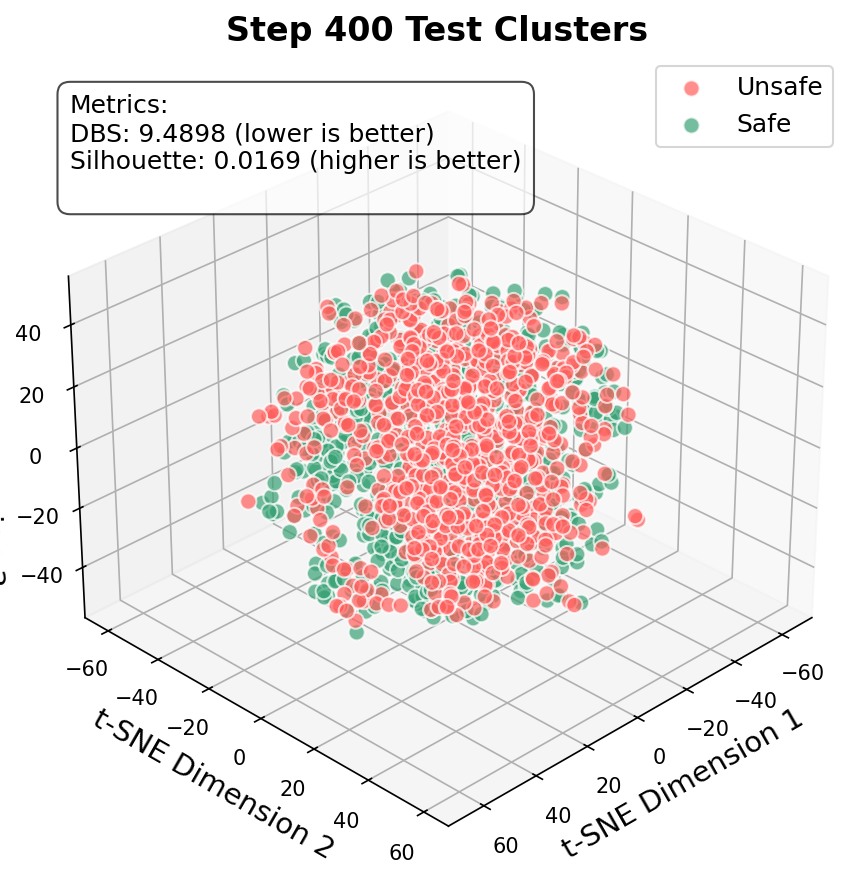

INFO:root:Epoch: 1/3, Step: 450, Loss: 1.5754, Task Loss: 1.5679, SC Loss: 0.0750, Null Space: 0.0000, Current SC: -0.0593, Base SC: 0.0157, Distance Ratio: 0.2844
INFO:root:Epoch: 1/3, Step: 500, Loss: 1.5033, Task Loss: 1.4970, SC Loss: 0.0634, Null Space: 0.0000, Current SC: -0.0477, Base SC: 0.0157, Distance Ratio: 1.2637
INFO:root:Epoch: 1/3, Step: 550, Loss: 1.4307, Task Loss: 1.4231, SC Loss: 0.0762, Null Space: 0.0000, Current SC: -0.0606, Base SC: 0.0157, Distance Ratio: 1.3252
INFO:root:Epoch: 1/3, Step: 600, Loss: 1.5697, Task Loss: 1.5562, SC Loss: 0.1349, Null Space: 0.0000, Current SC: -0.1192, Base SC: 0.0157, Distance Ratio: 1.0010
INFO:root:Epoch: 1/3, Step: 650, Loss: 1.6633, Task Loss: 1.6584, SC Loss: 0.0485, Null Space: 0.0000, Current SC: -0.0328, Base SC: 0.0157, Distance Ratio: 1.2109
INFO:root:Epoch: 1/3, Step: 700, Loss: 1.4696, Task Loss: 1.4599, SC Loss: 0.0970, Null Space: 0.0000, Current SC: -0.0813, Base SC: 0.0157, Distance Ratio: 1.3896
INFO:root:Epoch:

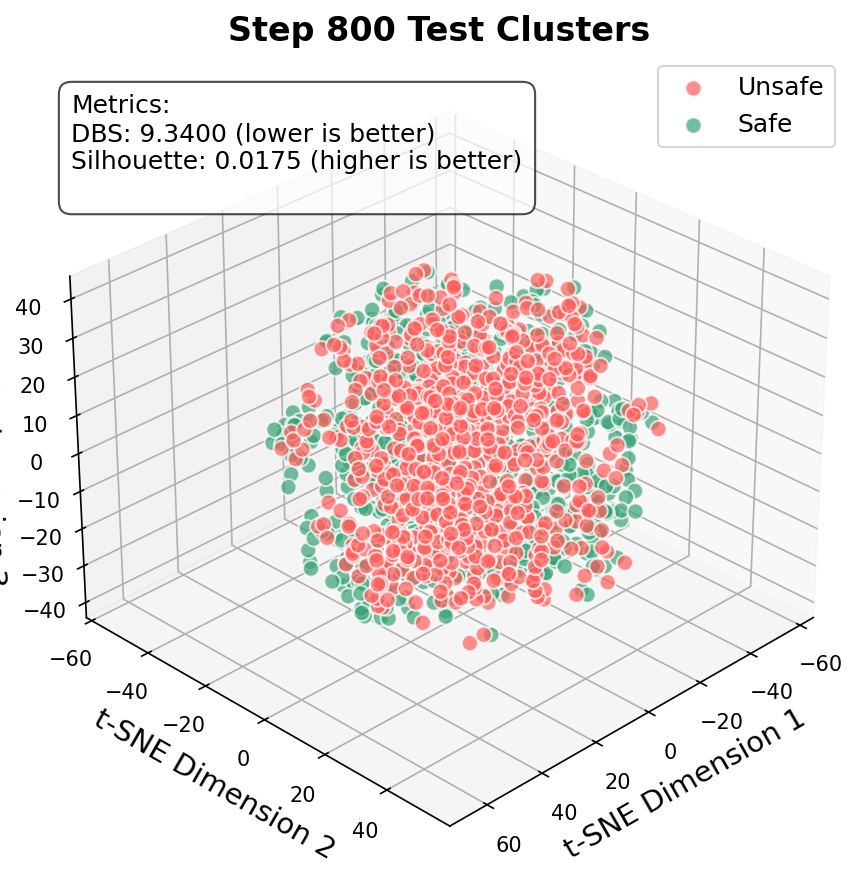

INFO:root:Epoch: 1/3, Step: 850, Loss: 1.3448, Task Loss: 1.3394, SC Loss: 0.0547, Null Space: 0.0000, Current SC: -0.0390, Base SC: 0.0157, Distance Ratio: 1.6230
INFO:root:Epoch: 1/3, Step: 900, Loss: 1.0805, Task Loss: 1.0573, SC Loss: 0.2322, Null Space: 0.0000, Current SC: -0.2165, Base SC: 0.0157, Distance Ratio: 0.2844
INFO:root:Epoch: 1/3, Step: 950, Loss: 1.3632, Task Loss: 1.3586, SC Loss: 0.0462, Null Space: 0.0000, Current SC: 0.0619, Base SC: 0.0157, Distance Ratio: 1.9307
INFO:root:Epoch: 1/3, Step: 1000, Loss: 1.5977, Task Loss: 1.5899, SC Loss: 0.0779, Null Space: 0.0000, Current SC: -0.0622, Base SC: 0.0157, Distance Ratio: 0.2527
INFO:root:Epoch: 1/3, Step: 1050, Loss: 1.3770, Task Loss: 1.3642, SC Loss: 0.1282, Null Space: 0.0000, Current SC: -0.1125, Base SC: 0.0157, Distance Ratio: 0.9727
INFO:root:Epoch: 1/3, Step: 1100, Loss: 1.4638, Task Loss: 1.4528, SC Loss: 0.1094, Null Space: 0.0000, Current SC: -0.0938, Base SC: 0.0157, Distance Ratio: 0.2766
INFO:root:Epoc

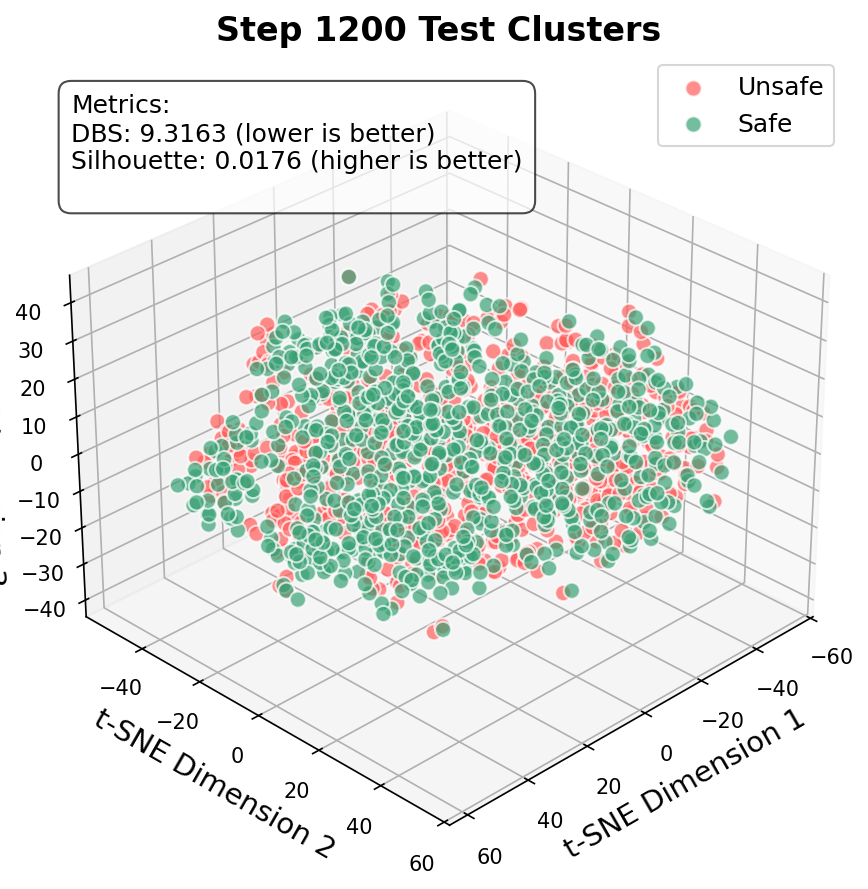

INFO:root:Epoch: 1/3, Step: 1250, Loss: 1.2974, Task Loss: 1.2973, SC Loss: 0.0010, Null Space: 0.0000, Current SC: 0.0167, Base SC: 0.0157, Distance Ratio: 0.9629
INFO:root:Epoch: 1/3, Step: 1300, Loss: 1.2372, Task Loss: 1.2196, SC Loss: 0.1761, Null Space: 0.0000, Current SC: -0.1604, Base SC: 0.0157, Distance Ratio: 1.0068
INFO:root:Epoch: 1/3, Step: 1350, Loss: 1.4481, Task Loss: 1.4429, SC Loss: 0.0521, Null Space: 0.0000, Current SC: -0.0364, Base SC: 0.0157, Distance Ratio: 0.8604
INFO:root:Epoch: 1/3, Step: 1400, Loss: 1.3141, Task Loss: 1.3110, SC Loss: 0.0308, Null Space: 0.0000, Current SC: -0.0151, Base SC: 0.0157, Distance Ratio: 0.8472
INFO:root:Epoch: 1/3, Step: 1450, Loss: 1.4330, Task Loss: 1.4306, SC Loss: 0.0234, Null Space: 0.0000, Current SC: 0.0391, Base SC: 0.0157, Distance Ratio: 0.9800
INFO:root:Epoch: 1/3, Step: 1500, Loss: 1.5033, Task Loss: 1.4938, SC Loss: 0.0959, Null Space: 0.0000, Current SC: -0.0802, Base SC: 0.0157, Distance Ratio: 1.2256
INFO:root:Ep

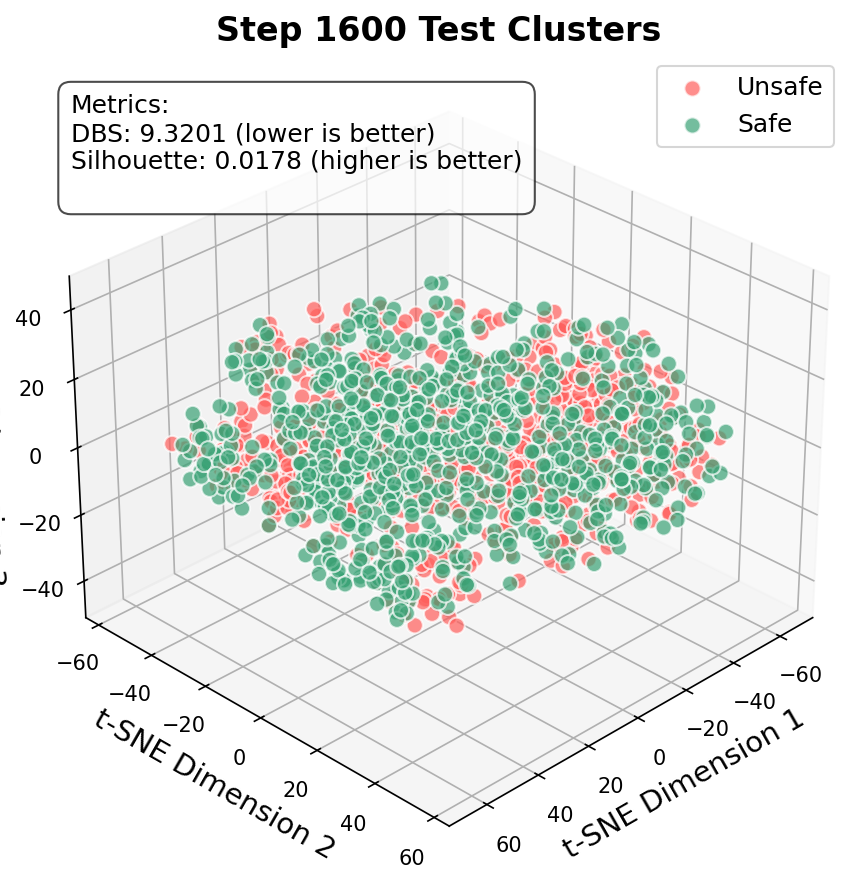

INFO:root:Epoch: 1/3, Step: 1650, Loss: 1.0879, Task Loss: 1.0761, SC Loss: 0.1186, Null Space: 0.0000, Current SC: -0.1029, Base SC: 0.0157, Distance Ratio: 1.2324
INFO:root:Epoch: 1/3, Step: 1700, Loss: 1.2079, Task Loss: 1.1921, SC Loss: 0.1586, Null Space: 0.0000, Current SC: -0.1429, Base SC: 0.0157, Distance Ratio: 0.7852
INFO:root:Epoch: 1/3, Step: 1750, Loss: 1.3151, Task Loss: 1.3069, SC Loss: 0.0822, Null Space: 0.0000, Current SC: -0.0665, Base SC: 0.0157, Distance Ratio: 1.1836
INFO:root:Epoch: 1/3, Step: 1800, Loss: 1.5565, Task Loss: 1.5407, SC Loss: 0.1582, Null Space: 0.0000, Current SC: -0.1425, Base SC: 0.0157, Distance Ratio: 0.2581
INFO:root:Epoch: 1/3, Step: 1850, Loss: 1.2996, Task Loss: 1.2929, SC Loss: 0.0668, Null Space: 0.0000, Current SC: -0.0511, Base SC: 0.0157, Distance Ratio: 0.8149
INFO:root:Epoch 1/3 completed. Avg Loss: 1.4379, Avg Task Loss: 1.4287, Avg SC Loss: 0.0927, Avg Null Space Loss: 0.0000
INFO:root:New best alignment! Saving to ./safelora_out

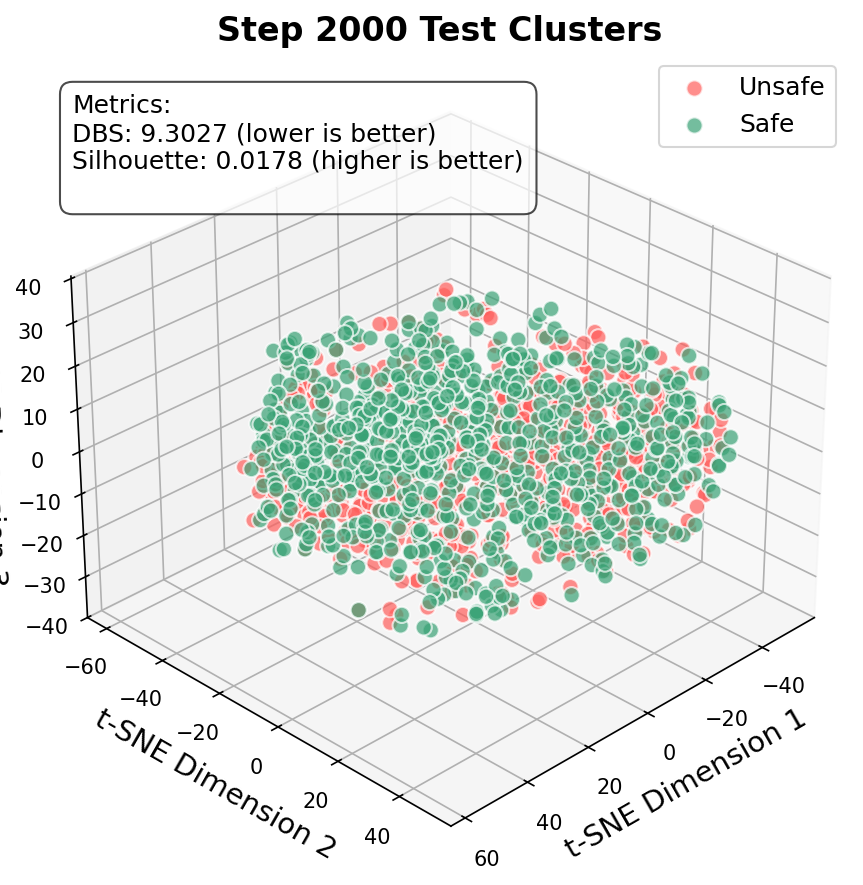

INFO:root:Epoch: 2/3, Step: 2050, Loss: 1.2728, Task Loss: 1.2576, SC Loss: 0.1523, Null Space: 0.0000, Current SC: -0.1366, Base SC: 0.0157, Distance Ratio: 0.8677
INFO:root:Epoch: 2/3, Step: 2100, Loss: 1.3480, Task Loss: 1.3366, SC Loss: 0.1132, Null Space: 0.0000, Current SC: -0.0975, Base SC: 0.0157, Distance Ratio: 1.4229


KeyboardInterrupt: 

In [8]:
# SafeLoRA training cell using default values and HF datasets

import os
import logging
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Config and paths
model_path = "meta-llama/Llama-3.2-1B"
output_dir = "./safelora_output"
lora_r = 8
lambda_sc = 0.1
lambda_null = 0.1
num_epochs = 3
batch_size = 8
learning_rate = 2e-5
max_length = 512
gradient_accumulation_steps = 1
safety_threshold = 0.95
enable_poison_detection = False
test_prompts = None

# Print alignment preservation settings
logger.info("Alignment preservation settings:")
logger.info(f"  - Silhouette Coef. Weight (λSC): {lambda_sc}")
logger.info(f"  - Null-Space Proj. Weight (λnull): {lambda_null}")
logger.info(f"  - Poison Detection: {'Enabled' if enable_poison_detection else 'Disabled'}")
if enable_poison_detection:
    logger.info(f"  - Poison Detection Threshold: {safety_threshold}")

# SafeLoRA config
config = SafeLoRAConfig(
    lambda_sc=lambda_sc,
    lambda_null=lambda_null,
    poison_threshold=safety_threshold,
    lora_r=lora_r,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    enable_poison_detection=enable_poison_detection,
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    logger.info(f"Added pad token. Tokenizer size: {len(tokenizer)}")

# Initialize SafeLoRA
logger.info("Initializing SafeLoRA for alignment-preserved fine-tuning...")
safe_lora = SafeLoRAModel(model_path, config, tokenizer)

# Load safe and unsafe datasets from HuggingFace
# Load and split datasets
safe_train, unsafe_train, safe_test, unsafe_test = load_and_split_safe_unsafe_datasets(
    safe_dataset_name="utk6/safe_dataset_gretel",
    unsafe_dataset_name="utk6/unsafe_dataset_gretel",
    test_size=0.1
)

# Build alternated train and test datasets
train_texts, train_labels, train_safety_labels = load_data_from_huggingface_datasets(safe_train, unsafe_train)
test_texts, test_labels, test_safety_labels = load_data_from_huggingface_datasets(safe_test, unsafe_test)

# Tokenized Datasets
train_dataset = SafetyDataset(train_texts, train_labels, train_safety_labels, tokenizer, max_length=max_length)
test_dataset = SafetyDataset(test_texts, test_labels, test_safety_labels, tokenizer, max_length=max_length)
print(len(train_dataset))
# SafeLoRA training cell using default values and HF datasets

import os
import logging
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Config and paths
model_path = "meta-llama/Llama-3.2-1B"
output_dir = "./safelora_output"
lora_r = 8
lambda_sc = 0.1
lambda_null = 0.1
num_epochs = 3
batch_size = 8
learning_rate = 2e-5
max_length = 512
gradient_accumulation_steps = 1
safety_threshold = 0.95
enable_poison_detection = False
test_prompts = None

# Print alignment preservation settings
logger.info("Alignment preservation settings:")
logger.info(f"  - Silhouette Coef. Weight (λSC): {lambda_sc}")
logger.info(f"  - Null-Space Proj. Weight (λnull): {lambda_null}")
logger.info(f"  - Poison Detection: {'Enabled' if enable_poison_detection else 'Disabled'}")
if enable_poison_detection:
    logger.info(f"  - Poison Detection Threshold: {safety_threshold}")

# SafeLoRA config
config = SafeLoRAConfig(
    lambda_sc=lambda_sc,
    lambda_null=lambda_null,
    poison_threshold=safety_threshold,
    lora_r=lora_r,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    enable_poison_detection=enable_poison_detection,
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    logger.info(f"Added pad token. Tokenizer size: {len(tokenizer)}")

# Initialize SafeLoRA
logger.info("Initializing SafeLoRA for alignment-preserved fine-tuning...")
safe_lora = SafeLoRAModel(model_path, config, tokenizer)

# Load safe and unsafe datasets from HuggingFace
# Load and split datasets
safe_train, unsafe_train, safe_test, unsafe_test = load_and_split_safe_unsafe_datasets(
    safe_dataset_name="utk6/safe_dataset_gretel",
    unsafe_dataset_name="utk6/unsafe_dataset_gretel",
    test_size=0.1
)

# Build alternated train and test datasets
train_texts, train_labels, train_safety_labels = load_data_from_huggingface_datasets(safe_train, unsafe_train)
test_texts, test_labels, test_safety_labels = load_data_from_huggingface_datasets(safe_test, unsafe_test)

# Tokenized Datasets
train_dataset = SafetyDataset(train_texts, train_labels, train_safety_labels, tokenizer, max_length=max_length)
test_dataset = SafetyDataset(test_texts, test_labels, test_safety_labels, tokenizer, max_length=max_length)
print("train size: ",len(train_dataset))
print("test size",len(test_dataset))
eval_dataset = None

# Fine-tune model
logger.info("Starting fine-tuning with alignment preservation...")
safe_lora.train(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    eval_dataset=eval_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    output_dir=output_dir,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

# Inference
logger.info(f"Training complete. Model saved to {output_dir}")
if test_prompts:
    run_inference(model_path, output_dir, test_prompts)

eval_dataset = None

# Fine-tune model
logger.info("Starting fine-tuning with alignment preservation...")
safe_lora.train(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    eval_dataset=eval_dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    output_dir=output_dir,
    gradient_accumulation_steps=gradient_accumulation_steps,
)

# Inference
logger.info(f"Training complete. Model saved to {output_dir}")
if test_prompts:
    run_inference(model_path, output_dir, test_prompts)
